In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [2]:
df = pd.read_csv('Data/UNSW_NB15_training-set.csv')

In [3]:
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

2024-11-19 16:43:49.098582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training Isolation Forest...
Training One-Class SVM with reduced data and fixed parameters...
Training Autoencoder with adjusted architecture...


2024-11-19 16:44:11.533041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1096/1096 [==============================] - 1s 526us/step

Isolation Forest Evaluation:
              precision    recall  f1-score   support

           0       0.43      0.88      0.58     37000
           1       0.39      0.06      0.11     45332

    accuracy                           0.43     82332
   macro avg       0.41      0.47      0.34     82332
weighted avg       0.41      0.43      0.32     82332



<Figure size 800x600 with 0 Axes>

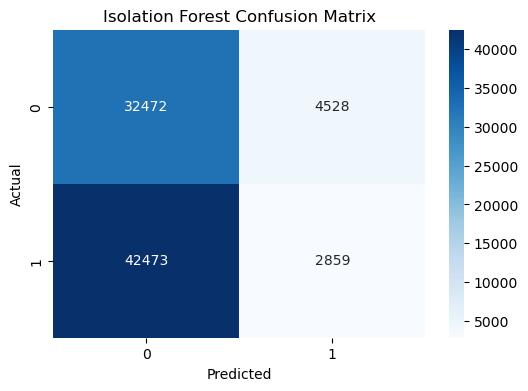


One-Class SVM Evaluation:
              precision    recall  f1-score   support

           0       0.51      0.93      0.65     37000
           1       0.81      0.26      0.40     45332

    accuracy                           0.56     82332
   macro avg       0.66      0.59      0.53     82332
weighted avg       0.68      0.56      0.51     82332



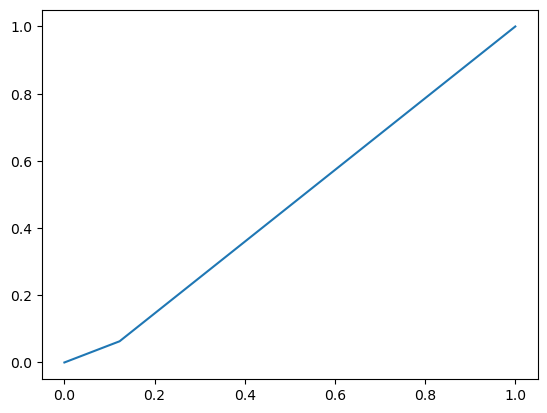

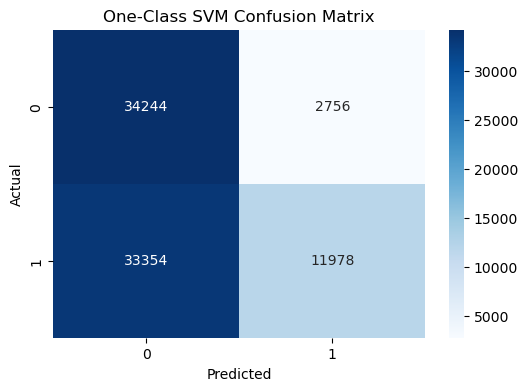


Autoencoder Evaluation:
              precision    recall  f1-score   support

           0       0.44      0.93      0.60     37000
           1       0.29      0.02      0.04     45332

    accuracy                           0.43     82332
   macro avg       0.36      0.48      0.32     82332
weighted avg       0.36      0.43      0.29     82332



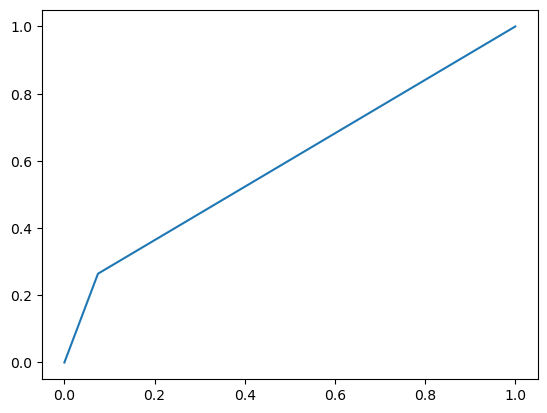

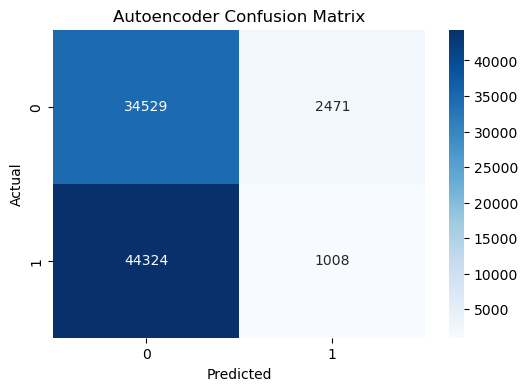

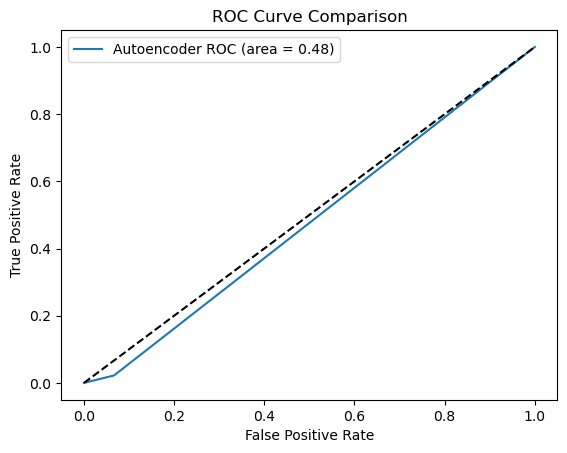

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np

# For preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# For feature selection and dimensionality reduction
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

# For models
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# For evaluation
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Load the data
train_data = pd.read_csv('Data/UNSW_NB15_training-set.csv')
test_data = pd.read_csv('Data/UNSW_NB15_testing-set.csv')

# Preprocess the data
# Concatenate train and test data for consistent preprocessing
full_data = pd.concat([train_data, test_data], ignore_index=True)

# Remove 'id' column
if 'id' in full_data.columns:
    full_data.drop('id', axis=1, inplace=True)

# Encode categorical variables
categorical_cols = ['proto', 'service', 'state']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    full_data[col] = le.fit_transform(full_data[col])
    label_encoders[col] = le

# Drop 'attack_cat' column
if 'attack_cat' in full_data.columns:
    full_data.drop('attack_cat', axis=1, inplace=True)

# Separate labels
labels = full_data['label']
full_data.drop('label', axis=1, inplace=True)

# Feature scaling
scaler = StandardScaler()
features = scaler.fit_transform(full_data)

# Feature Engineering

# 1. Remove low variance features
selector = VarianceThreshold(threshold=0.01)
features_var = selector.fit_transform(features)

# 2. Remove highly correlated features
features_df = pd.DataFrame(features_var)
corr_matrix = features_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
features_df.drop(columns=to_drop, inplace=True)
features_selected = features_df.values

# 3. Dimensionality Reduction using PCA
pca = PCA(n_components=0.95)  # Preserve 95% of variance
features_pca = pca.fit_transform(features_selected)

# Split back into train and test sets
train_size = train_data.shape[0]
X_train_full = features_pca[:train_size]
X_test = features_pca[train_size:]
y_train_full = labels[:train_size].values
y_test = labels[train_size:].values

# Further split X_train_full into training and validation sets
# We'll use the validation set for hyperparameter tuning
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

# Implement models with adjusted hyperparameter tuning

# 1. Isolation Forest with Default Parameters
print("Training Isolation Forest...")
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.1,
    random_state=42,
    n_jobs=-1
)
iso_forest.fit(X_train)
y_pred_iso = iso_forest.predict(X_test)
# Convert prediction labels (-1 for anomaly, 1 for normal) to (1 for anomaly, 0 for normal)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

# 2. One-Class SVM with Reduced Data and Fixed Parameters
print("Training One-Class SVM with reduced data and fixed parameters...")
# Fit on a smaller subset of normal data
X_train_normal = X_train[y_train == 0]

# Use a smaller subset to speed up training
if X_train_normal.shape[0] > 10000:
    X_train_normal_sub, _, = train_test_split(
        X_train_normal, test_size=0.9, random_state=42
    )
else:
    X_train_normal_sub = X_train_normal

# Use fixed reasonable parameters
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05, cache_size=1000)
oc_svm.fit(X_train_normal_sub)

# Predict on test data
y_pred_svm = oc_svm.predict(X_test)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

# 3. Autoencoder with Adjusted Architecture
print("Training Autoencoder with adjusted architecture...")

input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim, ))
encoder = Dense(16, activation="relu")(input_layer)
encoder = Dense(8, activation="relu")(encoder)
decoder = Dense(8, activation='relu')(encoder)
decoder = Dense(input_dim, activation='linear')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to prevent overfitting and reduce training time
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True
)

# Train the autoencoder on a smaller subset of normal data
X_train_auto = X_train[y_train == 0]

# Use a smaller subset to speed up training
if X_train_auto.shape[0] > 10000:
    X_train_auto_sub, _, = train_test_split(
        X_train_auto, test_size=0.9, random_state=42
    )
else:
    X_train_auto_sub = X_train_auto

history = autoencoder.fit(
    X_train_auto_sub, X_train_auto_sub,
    epochs=5,
    batch_size=256,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping],
    verbose=0
)

# Reconstruction error on test data
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Set threshold based on reconstruction error on validation data
X_val_pred = autoencoder.predict(X_val)
mse_val = np.mean(np.power(X_val - X_val_pred, 2), axis=1)
threshold = np.percentile(mse_val, 95)  # 95th percentile
y_pred_auto = np.where(mse > threshold, 1, 0)

# Evaluation Function
def evaluate_model(y_test, y_pred, model_name):
    print(f"\n{model_name} Evaluation:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Plot ROC curves
plt.figure(figsize=(8,6))

# Isolation Forest Evaluation
fpr_iso, tpr_iso, roc_auc_iso = evaluate_model(y_test, y_pred_iso, "Isolation Forest")
plt.plot(fpr_iso, tpr_iso, label='Isolation Forest ROC (area = %0.2f)' % roc_auc_iso)

# One-Class SVM Evaluation
fpr_svm, tpr_svm, roc_auc_svm = evaluate_model(y_test, y_pred_svm, "One-Class SVM")
plt.plot(fpr_svm, tpr_svm, label='One-Class SVM ROC (area = %0.2f)' % roc_auc_svm)

# Autoencoder Evaluation
fpr_auto, tpr_auto, roc_auc_auto = evaluate_model(y_test, y_pred_auto, "Autoencoder")
plt.plot(fpr_auto, tpr_auto, label='Autoencoder ROC (area = %0.2f)' % roc_auc_auto)

# Final ROC Curve
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


Training Random Forest Classifier...


/Users/ericluong/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/ericluong/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/ericluong/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_fea

Best parameters found: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}

Validation Performance:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     11200
           1       0.96      0.98      0.97     23869

    accuracy                           0.96     35069
   macro avg       0.96      0.95      0.95     35069
weighted avg       0.96      0.96      0.96     35069


Random Forest Evaluation:
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     37000
           1       0.82      0.98      0.89     45332

    accuracy                           0.87     82332
   macro avg       0.89      0.86      0.86     82332
weighted avg       0.89      0.87      0.87     82332



<Figure size 800x600 with 0 Axes>

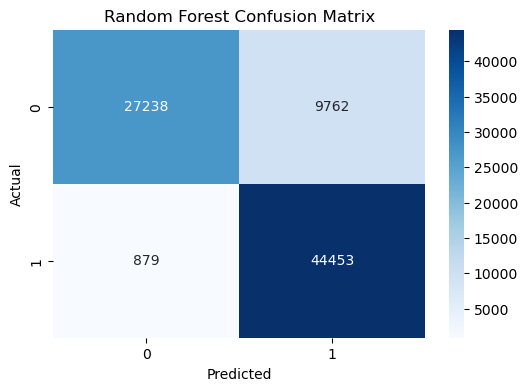

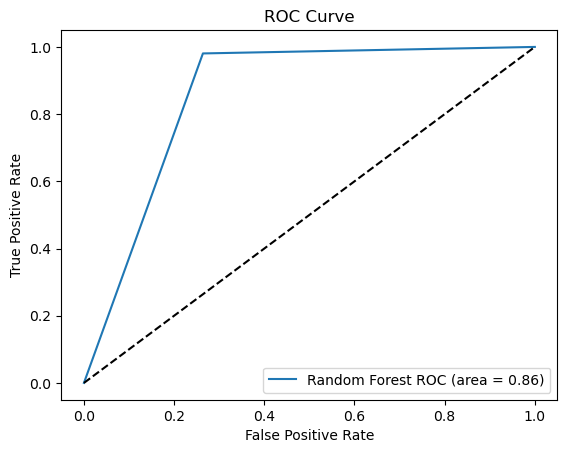

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np

# For preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# For models
from sklearn.ensemble import RandomForestClassifier

# For feature selection
from sklearn.feature_selection import SelectFromModel

# For hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
train_data = pd.read_csv('Data/UNSW_NB15_training-set.csv')
test_data = pd.read_csv('Data/UNSW_NB15_testing-set.csv')

# Preprocess the data
# Concatenate train and test data for consistent preprocessing
full_data = pd.concat([train_data, test_data], ignore_index=True)

# Remove 'id' column if present
if 'id' in full_data.columns:
    full_data.drop('id', axis=1, inplace=True)

# Encode categorical variables
categorical_cols = ['proto', 'service', 'state']
for col in categorical_cols:
    le = LabelEncoder()
    full_data[col] = le.fit_transform(full_data[col])

# Drop 'attack_cat' column if present
if 'attack_cat' in full_data.columns:
    full_data.drop('attack_cat', axis=1, inplace=True)

# Separate features and labels
labels = full_data['label']
features = full_data.drop('label', axis=1)

# Feature scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split back into train and test sets
train_size = train_data.shape[0]
X = features_scaled[:train_size]
X_test = features_scaled[train_size:]
y = labels[:train_size].values
y_test = labels[train_size:].values

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Implement a Random Forest Classifier with Hyperparameter Tuning
print("Training Random Forest Classifier...")

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1_macro',
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_
print("Best parameters found:", random_search.best_params_)

# Feature Importance
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Select top features
top_n = 20  # Number of top features to select
selected_indices = indices[:top_n]
X_train_selected = X_train[:, selected_indices]
X_val_selected = X_val[:, selected_indices]
X_test_selected = X_test[:, selected_indices]

# Retrain the model on selected features
best_rf.fit(X_train_selected, y_train)

# Predict on validation set
y_val_pred = best_rf.predict(X_val_selected)
print("\nValidation Performance:")
print(classification_report(y_val, y_val_pred))

# Predict on test data
y_pred_rf = best_rf.predict(X_test_selected)

# Evaluation Function
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Evaluation:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Evaluate Random Forest
plt.figure(figsize=(8,6))

fpr_rf, tpr_rf, roc_auc_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")
plt.plot(fpr_rf, tpr_rf, label='Random Forest ROC (area = %0.2f)' % roc_auc_rf)

# Final ROC Curve
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# For preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# For models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# For hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Load the data
train_data = pd.read_csv('Data/UNSW_NB15_training-set.csv')
test_data = pd.read_csv('Data/UNSW_NB15_testing-set.csv')

# Preprocess the data
# Concatenate train and test data for consistent preprocessing
full_data = pd.concat([train_data, test_data], ignore_index=True)

# Remove 'id' column if present
if 'id' in full_data.columns:
    full_data.drop('id', axis=1, inplace=True)

# Encode categorical variables
categorical_cols = ['proto', 'service', 'state']
for col in categorical_cols:
    le = LabelEncoder()
    full_data[col] = le.fit_transform(full_data[col])

# Drop 'attack_cat' column if present
if 'attack_cat' in full_data.columns:
    full_data.drop('attack_cat', axis=1, inplace=True)

# Separate features and labels
labels = full_data['label']
features = full_data.drop('label', axis=1)

# Feature scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split back into train and test sets
train_size = train_data.shape[0]
X = features_scaled[:train_size]
X_test = features_scaled[train_size:]
y = labels[:train_size].values
y_test = labels[train_size:].values

# Split the training data into training and validation sets
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature Selection using Random Forest
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_train_full, y_train_full)
importances = rf_selector.feature_importances_
indices = np.argsort(importances)[::-1]

# Select top features (e.g., top 40)
top_n = 40
selected_indices = indices[:top_n]
X_train = X_train_full[:, selected_indices]
X_val = X_val[:, selected_indices]
X_test_selected = X_test[:, selected_indices]

# Implement Random Forest Classifier with Hyperparameter Tuning
print("Training Random Forest Classifier...")

# Update the parameter grid
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 20, 30, 40],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize Random Forest Classifier with class_weight
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

# Use RandomizedSearchCV for hyperparameter tuning
random_search_rf = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_dist_rf,
    n_iter=10,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=3),
    random_state=42,
    n_jobs=-1
)

random_search_rf.fit(X_train, y_train_full)
best_rf = random_search_rf.best_estimator_
print("Best parameters found for Random Forest:", random_search_rf.best_params_)

# Retrain the model on selected features
best_rf.fit(X_train, y_train_full)

# Predict on validation set
y_val_pred_rf = best_rf.predict(X_val)
print("\nRandom Forest Validation Performance:")
print(classification_report(y_val, y_val_pred_rf))

# Predict on test data
y_pred_rf = best_rf.predict(X_test_selected)

# Implement XGBoost Classifier
print("\nTraining XGBoost Classifier...")

# Define parameter grid for XGBoost
param_dist_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'scale_pos_weight': [1, 2, 5]
}

xgb_classifier = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_dist_xgb,
    n_iter=10,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=3),
    random_state=42,
    n_jobs=-1
)

random_search_xgb.fit(X_train, y_train_full)
best_xgb = random_search_xgb.best_estimator_
print("Best parameters found for XGBoost:", random_search_xgb.best_params_)

# Predict on validation set
y_val_pred_xgb = best_xgb.predict(X_val)
print("\nXGBoost Validation Performance:")
print(classification_report(y_val, y_val_pred_xgb))

# Predict on test data
y_pred_xgb = best_xgb.predict(X_test_selected)

# Implement LightGBM Classifier
print("\nTraining LightGBM Classifier...")

# Define parameter grid for LightGBM
param_dist_lgb = {
    'n_estimators': [100, 200],
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'class_weight': ['balanced', None]
}

lgb_classifier = LGBMClassifier(
    objective='binary',
    random_state=42,
    n_jobs=-1
)

random_search_lgb = RandomizedSearchCV(
    estimator=lgb_classifier,
    param_distributions=param_dist_lgb,
    n_iter=10,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=3),
    random_state=42,
    n_jobs=-1
)

random_search_lgb.fit(X_train, y_train_full)
best_lgb = random_search_lgb.best_estimator_
print("Best parameters found for LightGBM:", random_search_lgb.best_params_)

# Predict on validation set
y_val_pred_lgb = best_lgb.predict(X_val)
print("\nLightGBM Validation Performance:")
print(classification_report(y_val, y_val_pred_lgb))

# Predict on test data
y_pred_lgb = best_lgb.predict(X_test_selected)

# Implement Neural Network Classifier
print("\nTraining Neural Network Classifier...")

model_nn = Sequential()
model_nn.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model_nn.add(Dropout(0.5))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dropout(0.5))
model_nn.add(Dense(1, activation='sigmoid'))

# Compile the model
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_nn.fit(X_train, y_train_full, epochs=10, batch_size=256, validation_data=(X_val, y_val), verbose=0)

# Predict on validation set
y_val_pred_nn_prob = model_nn.predict(X_val)
y_val_pred_nn = (y_val_pred_nn_prob > 0.5).astype(int).reshape(-1)
print("\nNeural Network Validation Performance:")
print(classification_report(y_val, y_val_pred_nn))

# Predict on test data
y_pred_nn_prob = model_nn.predict(X_test_selected)
y_pred_nn = (y_pred_nn_prob > 0.5).astype(int).reshape(-1)

# Evaluation Function
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Evaluation:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Evaluate all models on the test set
plt.figure(figsize=(8,6))

# Random Forest Evaluation
fpr_rf, tpr_rf, roc_auc_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")
plt.plot(fpr_rf, tpr_rf, label='Random Forest ROC (area = %0.2f)' % roc_auc_rf)

# XGBoost Evaluation
fpr_xgb, tpr_xgb, roc_auc_xgb = evaluate_model(y_test, y_pred_xgb, "XGBoost")
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost ROC (area = %0.2f)' % roc_auc_xgb)

# LightGBM Evaluation
fpr_lgb, tpr_lgb, roc_auc_lgb = evaluate_model(y_test, y_pred_lgb, "LightGBM")
plt.plot(fpr_lgb, tpr_lgb, label='LightGBM ROC (area = %0.2f)' % roc_auc_lgb)

# Neural Network Evaluation
fpr_nn, tpr_nn, roc_auc_nn = evaluate_model(y_test, y_pred_nn, "Neural Network")
plt.plot(fpr_nn, tpr_nn, label='Neural Network ROC (area = %0.2f)' % roc_auc_nn)

# Final ROC Curve
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'lightgbm'